# Import Librarys

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer

import warnings
import os

%matplotlib inline
warnings.simplefilter("ignore")

print(os.listdir("data"))

['Online Retail.xlsx', 'online+retail.zip']


# Data Preparation

In [2]:
data = r'data/Online Retail.xlsx'
df = pd.read_excel(data)
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [3]:
def check_data(df,head=5):
    print("-------------SHAPE---------------")
    print(df.shape)
    print("-------------INFO----------------")
    print(df.info())
    print("-----------DESCRIBE--------------")
    print(df.describe([0.01, 0.1, 0.25, 0.50, 0.75, 0.9, 0.95, 0.99]))
    print("----------NA VALUES--------------")
    print(df.isnull().sum())
    print("--------FIRST {} ROWS------------".format(head))
    print(df.head(head))
    
check_data(df)

-------------SHAPE---------------
(541909, 8)
-------------INFO----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None
-----------DESCRIBE--------------
            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853 

In [4]:
# Convert 'InvoiceDate' to a datetime object for date-based calculations
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Calculate the total spending for each transaction
df['TotalSpending'] = df['Quantity'] * df['UnitPrice']

# Calculate the recency of purchase for each customer
max_date = df['InvoiceDate'].max()
df['Recency'] = max_date - df.groupby('CustomerID')['InvoiceDate'].transform('max')

# Convert to the number of days
df['Recency'] = df['Recency'].dt.days  

# Calculate the order frequency for each customer
df['OrderFrequency'] = df.groupby('CustomerID')['InvoiceNo'].transform('nunique')

# Calculate the average basket size for each customer
df['BasketSize'] = df.groupby(['CustomerID', 'InvoiceNo'])['Quantity'].transform('sum')
df = df.drop_duplicates(subset=['CustomerID', 'InvoiceNo'])  

# Group data by CustomerID to obtain customer-level features
df = df.groupby('CustomerID').agg({
    'Recency': 'min',
    'OrderFrequency': 'mean',
    'TotalSpending': 'sum',
    'BasketSize': 'mean'
}).reset_index()

#df = df.drop(['Description', 'Country'], axis=1)

df.head(5)


,CustomerID,Recency,OrderFrequency,TotalSpending,BasketSize
0,12346.0,325.0,2.0,0.00,0.000000
1,12347.0,1.0,7.0,163.16,351.142857
2,12348.0,74.0,4.0,331.36,585.250000
3,12349.0,18.0,1.0,15.00,631.000000
4,12350.0,309.0,1.0,25.20,197.000000


In [5]:
check_data(df)

-------------SHAPE---------------
(4372, 5)
-------------INFO----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4372 entries, 0 to 4371
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      4372 non-null   float64
 1   Recency         4372 non-null   float64
 2   OrderFrequency  4372 non-null   float64
 3   TotalSpending   4372 non-null   float64
 4   BasketSize      4372 non-null   float64
dtypes: float64(5)
memory usage: 170.9 KB
None
-----------DESCRIBE--------------
         CustomerID      Recency  OrderFrequency  TotalSpending    BasketSize
count   4372.000000  4372.000000     4372.000000    4372.000000   4372.000000
mean   15299.677722    91.047118        5.075480     188.430071    196.806749
std     1722.390705   100.765435        9.338754    1046.488801    321.139570
min    12346.000000     0.000000        1.000000   -7899.590000   -244.000000
1%     12401.710000     0.0000

In [6]:
def select_county(df, country):
    country_df = df.loc(df['Country'] == country)
    return country_df

In [7]:
def outlier_thresholds(df,col_name,q1=0.05,q3=0.95):
    quartile1= df[col_name].quantile(q1)
    quartile3= df[col_name].quantile(q3)
    inquantile_range= quartile3 - quartile1
    up_limit=quartile3 + 1.5 * inquantile_range
    low_limit=quartile1 - 1.5 * inquantile_range
    return low_limit, up_limit

def check_outlier(df, col_name, q1=0.05,q3=0.95):
    low_limit, up_limit = outlier_thresholds(df,col_name,q1,q3)
    if (df[ (df[col_name] > up_limit) | (df[col_name] < low_limit)]).any(axis=None):
        return True
    else:
        return False
def replace_with_thresholds(df,col_name):
    low_limit, up_limit = outlier_thresholds(df,col_name)
    df.loc[(df[col_name] < low_limit), col_name]= low_limit
    df.loc[(df[col_name] > up_limit ), col_name]= up_limit

In [8]:
for col in df.columns:
    print(col, check_outlier(df, col))

CustomerID False
Recency False
OrderFrequency True
TotalSpending True
BasketSize True


In [9]:
for col in df.columns:
    replace_with_thresholds(df, col)
check_data(df)

-------------SHAPE---------------
(4372, 5)
-------------INFO----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4372 entries, 0 to 4371
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      4372 non-null   float64
 1   Recency         4372 non-null   float64
 2   OrderFrequency  4372 non-null   float64
 3   TotalSpending   4372 non-null   float64
 4   BasketSize      4372 non-null   float64
dtypes: float64(5)
memory usage: 170.9 KB
None
-----------DESCRIBE--------------
         CustomerID      Recency  OrderFrequency  TotalSpending   BasketSize
count   4372.000000  4372.000000     4372.000000    4372.000000  4372.000000
mean   15299.677722    91.047118        4.773788     125.130817   186.892885
std     1722.390705   100.765435        6.073273     266.604844   184.103981
min    12346.000000     0.000000        1.000000    -878.522500  -244.000000
1%     12401.710000     0.000000   

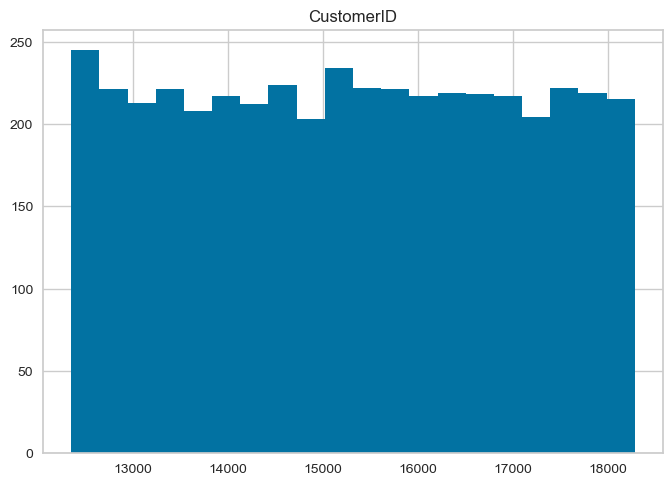

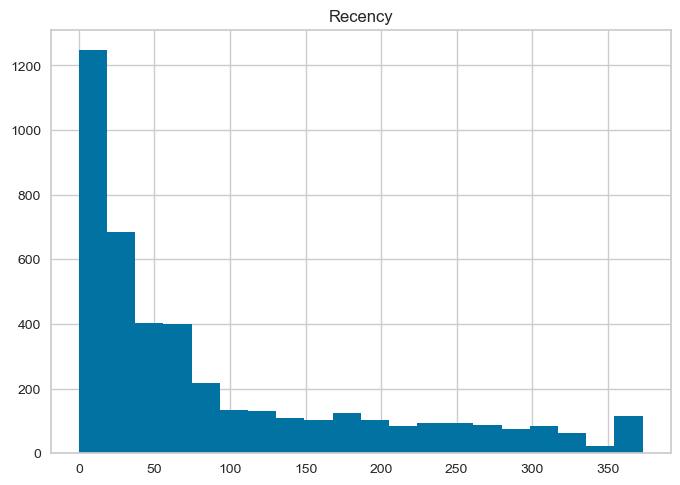

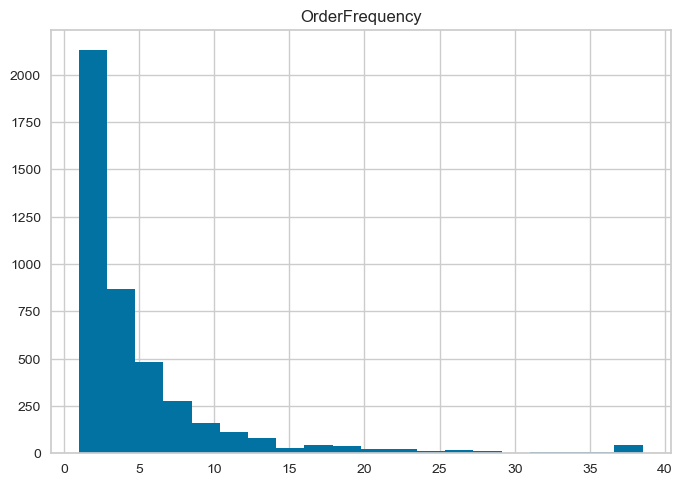

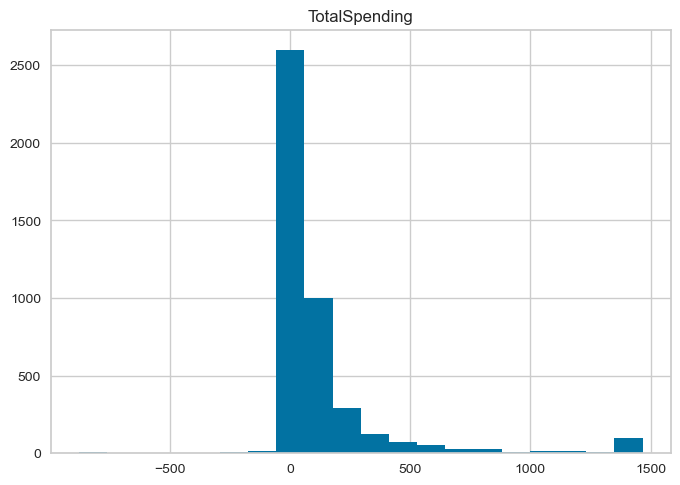

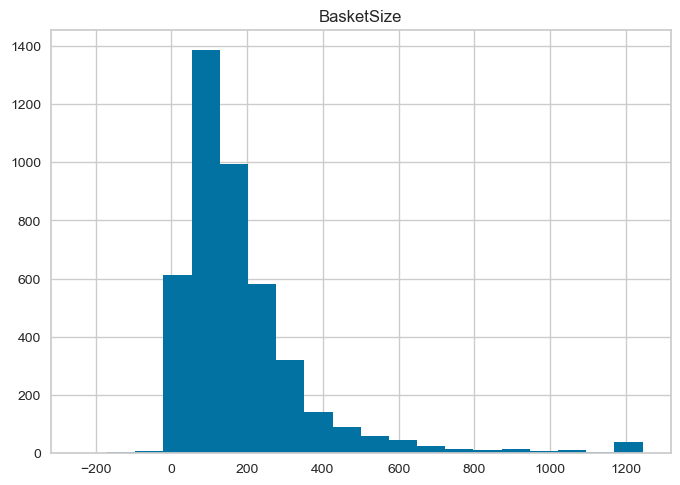

In [10]:
for col in df.columns:
    df[col].hist(bins=20)
    plt.title(col)
    plt.show()

In [11]:
# Exclude categorical columns before PCA
num_col = df.select_dtypes(include='number')

# Standardize numerical features for PCA
scale = StandardScaler()
scale_data = scale.fit_transform(num_col)

# Apply PCA to reduce dimensionality while retaining important features
pca = PCA(n_components=min(num_col.shape[0], num_col.shape[1]))
pca_result = pca.fit_transform(scale_data)

# Add PCA results to the DataFrame
for i in range(pca_result.shape[1]):
    df[f'PCA_Component_{i+1}'] = pca_result[:, i]
    
# Apply t-SNE on the PCA-reduced feature space
# Apply t-SNE on the PCA-reduced feature space
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(pca_result)
df['t-SNE_Component_1'] = tsne_result[:, 0]
df['t-SNE_Component_2'] = tsne_result[:, 1]

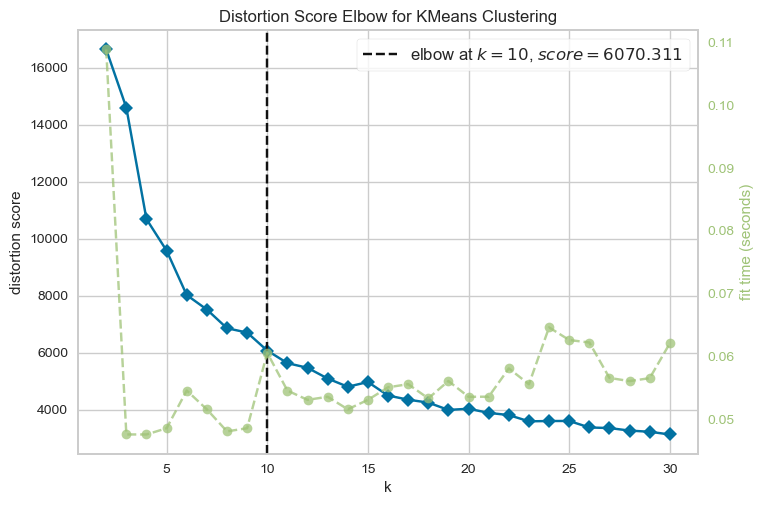

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [13]:
#KMEANS Optimal Numbers of Cluster
kmeans= KMeans(n_init="auto")
elbow = KElbowVisualizer(kmeans, k=30)
elbow.fit(scale_data)
elbow.show()

In [14]:
k_ = elbow.elbow_value_
kmeans= KMeans(n_init="auto", n_clusters=k_, random_state=42).fit(scale_data)

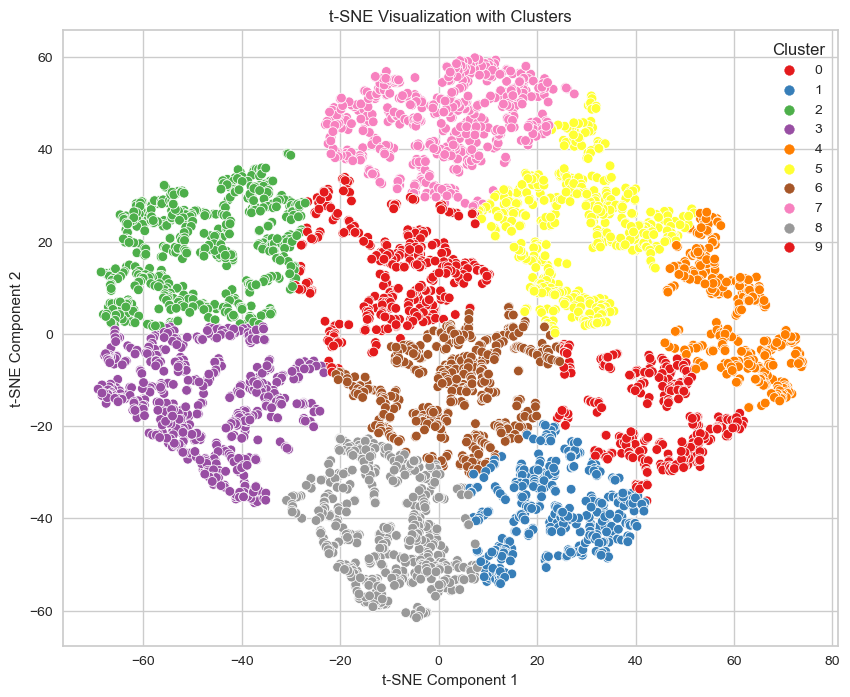

In [15]:
# Perform K-means clustering on the t-SNE-reduced feature space
df['Cluster'] = kmeans.fit_predict(tsne_result)

# Create a scatter plot of the t-SNE result with cluster coloring
plt.figure(figsize=(10, 8))
sns.scatterplot(x='t-SNE_Component_1', y='t-SNE_Component_2', hue='Cluster', data=df, palette='Set1')
plt.title('t-SNE Visualization with Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster', loc='upper right')
plt.show()

In [16]:
# Calculate cluster-specific metrics
cluster_metrics = df.groupby('Cluster').agg({
    'Recency': 'mean',            
    'OrderFrequency': 'mean',    
    'TotalSpending': 'mean',     
    'BasketSize': 'mean',        
}).reset_index()

# Rename the columns for clarity
cluster_metrics.columns = ['Cluster', 'AvgRecency', 'AvgPurchaseFrequency', 'AvgSpending', 'AvgBasketSize']

# Print or display the cluster metrics
print(cluster_metrics)

   Cluster  AvgRecency  AvgPurchaseFrequency  AvgSpending  AvgBasketSize
0        0   61.324324              2.610811    44.673811     129.012722
1        1   28.391781              5.747945    77.103644     185.053126
2        2  258.852941              1.556985    24.988116     143.262393
3        3  231.642447              2.032505    33.003160     107.401962
4        4   21.981538             18.492308   806.290577     288.250854
5        5   35.264000              5.920000   128.739180     355.162638
6        6   40.297727              2.522727    38.111591     236.900284
7        7   51.990724              2.528757    46.958845     152.154600
8        8   50.542443              2.262940    43.035859     101.351745
9        9   28.614841             11.876325   290.690247     216.422032


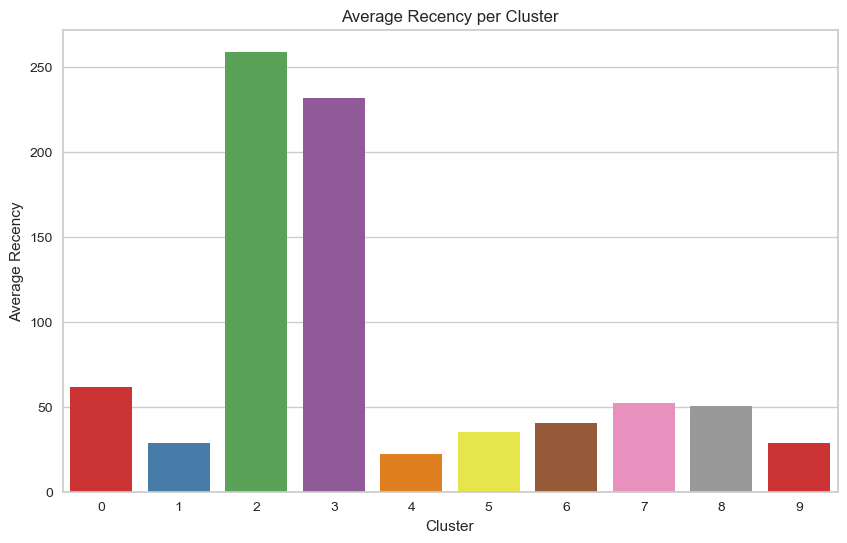

In [17]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='AvgRecency', data=cluster_metrics, palette='Set1')
plt.title('Average Recency per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Recency')
plt.show()

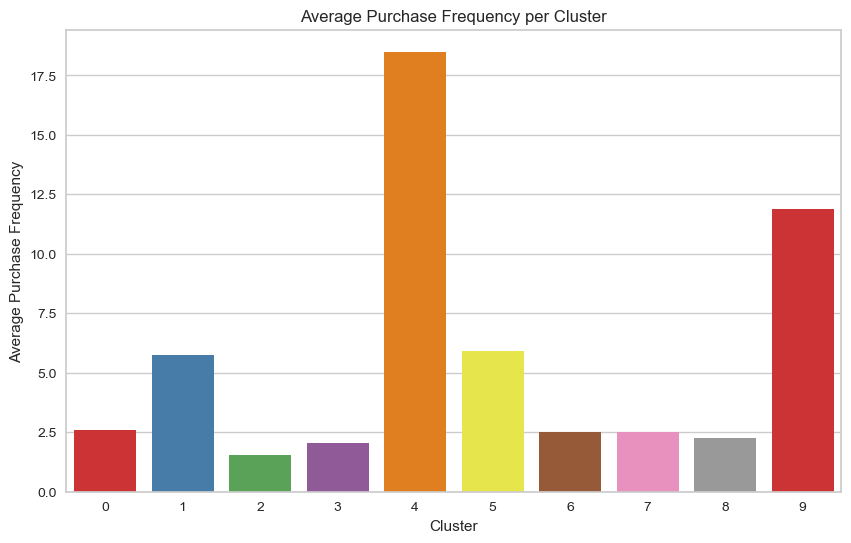

In [18]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='AvgPurchaseFrequency', data=cluster_metrics, palette='Set1')
plt.title('Average Purchase Frequency per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Purchase Frequency')
plt.show()

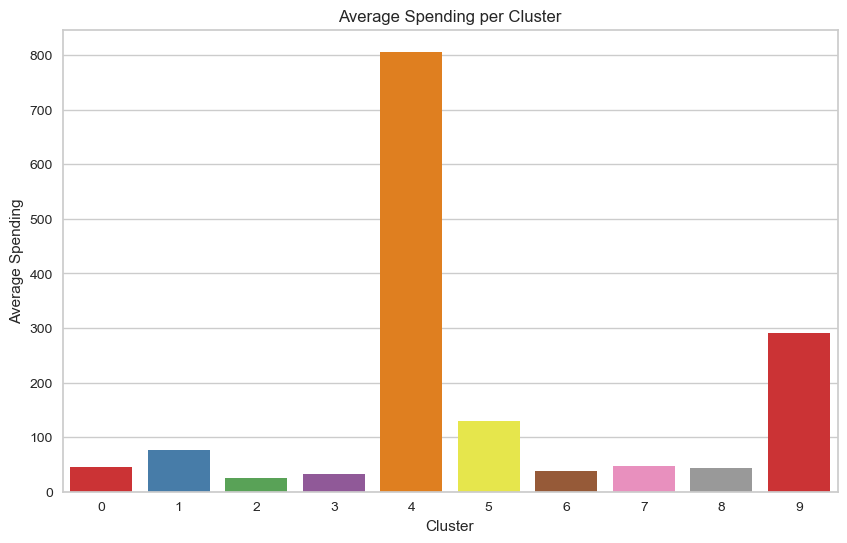

In [19]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='AvgSpending', data=cluster_metrics, palette='Set1')
plt.title('Average Spending per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Spending')
plt.show()

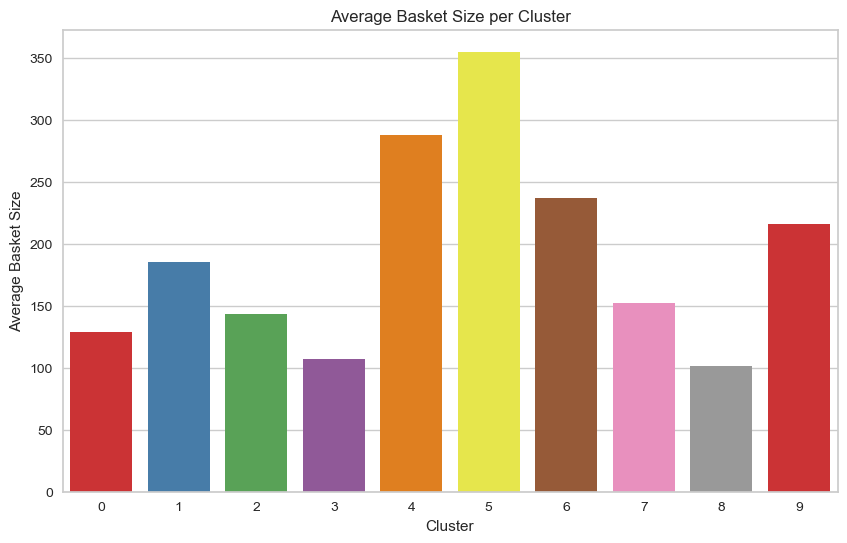

In [20]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='AvgBasketSize', data=cluster_metrics, palette='Set1')
plt.title('Average Basket Size per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Basket Size')
plt.show()